In [1]:
import sys
sys.path.append(r"C:\Users\laura\OneDrive - Imperial College London\project 2\Coding\New models\package\flexynesis")

In [3]:
import os
os.environ["OMP_NUM_THREADS"] = "1"
import flexynesis
import torch
torch.set_num_threads(4)

Seed set to 42


In [5]:
# parameters cell (required to pass arguments to the notebook) (see View -> show right sidebar -> add tag -> parameters)
HPO_ITER = 1 # number of HPO iterations for final modeling run

# data import and feature selection
import ==> folder;
data cleaning ==> exclude 方差太小的特征，imputation, exclude the feature with too many 缺失
select_features ==> unsupervised，laplacian score low, highly similar features(person>0.9, optional) are deleted
transformation==> standardize(z-score) / min_max
 或 'gene_id'，取决于你的数据格式

In [7]:
# real data organize

# data prepare
# data import LCMS, HDF

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
import warnings
warnings.filterwarnings("ignore")
import os
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
import seaborn as sns


# 1. 指定存放原始与新文件的文件夹
load_path = r"C:\Users\laura\OneDrive - Imperial College London\project 2\Yuting Project - Machine Learning Driven Integration - shared folder\data\preprocessed data"

# 3. after sample alignment
HDF = pd.read_csv(os.path.join(load_path, "S_HDF.csv"), index_col=0)
LD  = pd.read_csv(os.path.join(load_path, "S_LD.csv"),  index_col=0)
PM  = pd.read_csv(os.path.join(load_path, "S_PM.csv"),  index_col=0)
BM  = pd.read_csv(os.path.join(load_path, "S_BM.csv"),  index_col=0)

# metadata import
# female=1, male=0
# diabetic=1, nondiabetic=0
metadata = pd.read_excel(r"C:\Users\laura\OneDrive - Imperial College London\project 2\sample data.xlsx")

metadata['SampleId'] = metadata['SampleId'].astype(int)
HDF.index = HDF.index.astype(int)

merged_df = HDF.merge(
    metadata[['SampleId', 'SEX', 'DIAB', 'AGE', 'BMI']],
    left_index=True,
    right_on='SampleId'
)

merged_df['SEX_num'] = merged_df['SEX'].str.strip().str.lower().map({'female': 1, 'male': 0})
merged_df['DIAB_num'] = merged_df['DIAB'].str.strip().str.lower().map({'diabetic': 1, 'non-diabetic': 0})
print("Unmatched SEX values:", merged_df['SEX_num'].isna().sum())
print("Unmatched DIAB values:", merged_df['DIAB_num'].isna().sum())

y_dm = merged_df['DIAB_num']# diabetic=1, nondiabetic=0

# index alignment check
print(f"HDF shape: {HDF.shape}")
print(f"LD shape: {LD.shape}")
print(f"PM shape: {PM.shape}")
print(f"BM shape: {BM.shape}")


# Train-test split
y_dm.index = HDF.index
HDF_train, HDF_test, y_train, y_test = train_test_split(HDF, y_dm, test_size=0.3, random_state=42)
# Split LD, PM, BM using the same indices as HDF
LD_train = LD.loc[HDF_train.index]
LD_test  = LD.loc[HDF_test.index]

PM_train = PM.loc[HDF_train.index]
PM_test  = PM.loc[HDF_test.index]

BM_train = BM.loc[HDF_train.index]
BM_test  = BM.loc[HDF_test.index]

Y_train = y_dm.loc[HDF_train.index]
Y_test  = y_dm.loc[HDF_test.index]

print("train HDF shape:", HDF_train.shape)
print("test HDF shape:", HDF_test.shape)
print("train y_dm shape", y_train.shape)
print("test y_dm shape:", y_test.shape)
print("LD_train shape:", LD_train.shape)
print("LD_test shape:", LD_test.shape)
print("PM_train shape:", PM_train.shape)
print("PM_test shape:", PM_test.shape)
print("BM_train shape:", BM_train.shape)
print("BM_test shape:", BM_test.shape)
print("Y_train shape:", Y_train.shape)
print("Y_test shape:", Y_test.shape)

Unmatched SEX values: 0
Unmatched DIAB values: 0
HDF shape: (282, 904)
LD shape: (282, 1149)
PM shape: (282, 501)
BM shape: (282, 161)
train HDF shape: (197, 904)
test HDF shape: (85, 904)
train y_dm shape (197,)
test y_dm shape: (85,)
LD_train shape: (197, 1149)
LD_test shape: (85, 1149)
PM_train shape: (197, 501)
PM_test shape: (85, 501)
BM_train shape: (197, 161)
BM_test shape: (85, 161)
Y_train shape: (197,)
Y_test shape: (85,)


In [34]:
import os

base_path = r"C:\Users\laura\OneDrive - Imperial College London\project 2\Coding\New models\package\flexynesis\dataset_DM"

train_path = os.path.join(base_path, "train")
test_path = os.path.join(base_path, "test")
os.makedirs(train_path, exist_ok=True)
os.makedirs(test_path, exist_ok=True)

# 训练集保存函数
def save_train(df, suffix, filename):
    df.columns = df.columns.astype(str) + f"_{suffix}"        # 样本ID加后缀
    df.index = df.index.astype(str).map(lambda x: "ID_" + x)  # 特征名加前缀
    df_t = df.T
    # 直接保存，保持行索引（样本ID）为CSV的索引
    df_t.to_csv(os.path.join(train_path, f"{filename}.csv"), index=True)

# 测试集保存函数
def save_test(df, suffix, filename):
    df.columns = df.columns.astype(str) + f"_{suffix}"
    df.index = df.index.astype(str).map(lambda x: "ID_" + x)
    df_t = df.T
    df_t.to_csv(os.path.join(test_path, f"{filename}.csv"), index=True)

# 临床训练数据保存
def save_clinical_train(series, filename):
    df = series.to_frame(name='clin')
    df.index = df.index.astype(str).map(lambda x: "ID_" + x)
    df.to_csv(os.path.join(train_path, f"{filename}.csv"), index=True)

# 临床测试数据保存
def save_clinical_test(series, filename):
    df = series.to_frame(name='clin')
    df.index = df.index.astype(str).map(lambda x: "ID_" + x)
    df.to_csv(os.path.join(test_path, f"{filename}.csv"), index=True)

# 保存训练集
save_train(LD_train, "LD", "LD")
save_train(PM_train, "PM", "PM")
save_train(BM_train, "BM", "BM")
save_train(HDF_train, "HDF", "HDF")
save_clinical_train(Y_train, "clin")

# 保存测试集
save_test(LD_test, "LD", "LD")
save_test(PM_test, "PM", "PM")
save_test(BM_test, "BM", "BM")
save_test(HDF_test, "HDF", "HDF")
save_clinical_test(Y_test, "clin")

print(" 所有文件已保存完毕，样本ID加后缀，特征名加前缀，索引正确保存。")


✅ 所有文件已保存完毕，样本ID加后缀，特征名加前缀，索引正确保存。


In [36]:
import pandas as pd
import os

base_path = r"C:\Users\laura\OneDrive - Imperial College London\project 2\Coding\New models\package\flexynesis\dataset_DM"
train_path = os.path.join(base_path, "train")
test_path = os.path.join(base_path, "test")

# 文件列表和对应变量名
file_varnames = ["LD", "PM", "BM", "HDF", "clin"]

# 读取训练集
for name in file_varnames:
    path = os.path.join(train_path, f"{name}.csv")
    if name == "clin":
        globals()[f"{name}_train"] = pd.read_csv(path, index_col=0)
    else:
        globals()[f"{name}_train"] = pd.read_csv(path)

# 读取测试集
for name in file_varnames:
    path = os.path.join(test_path, f"{name}.csv")
    if name == "clin":
        globals()[f"{name}_test"] = pd.read_csv(path, index_col=0)
    else:
        globals()[f"{name}_test"] = pd.read_csv(path)


In [38]:
HDF_train

,Unnamed: 0,ID_225,ID_68,ID_138,ID_282,ID_50,ID_210,ID_263,ID_71,ID_364,...,ID_109,ID_276,ID_150,ID_377,ID_28,ID_240,ID_88,ID_133,ID_360,ID_127
0,HDF38768_HDF,-0.493094,-0.326450,0.786272,0.712122,-0.516785,-0.017646,-0.895207,-1.108041,0.748308,...,-1.326280,-0.215718,-0.571208,-0.115411,-0.415063,0.428414,0.569645,-1.026196,-1.378165,0.011455
1,HDF38296_HDF,-0.623231,-0.765366,0.393284,0.586020,-0.843879,-0.042703,-0.829392,-1.246553,0.947446,...,-1.438369,0.019840,-0.615554,-0.330166,-0.620154,-0.582150,0.199517,-1.386788,-0.557755,0.131716
2,HDF57814_HDF,-0.172819,-0.445627,-1.593750,1.418843,-0.478150,-0.922154,-0.358789,-0.123846,-1.173759,...,0.218536,0.217142,-0.545094,0.480170,-0.525204,0.184764,-0.168050,2.394835,0.193901,-0.966521
3,HDF48762_HDF,-1.062064,-0.834395,2.169775,-1.095719,-0.894598,0.308134,-0.036728,0.319607,-0.094503,...,-0.704350,0.174646,1.068907,0.658223,1.229928,0.070961,-0.905517,2.046400,0.116198,-0.825762
4,HDF52603_HDF,-0.833507,1.072175,-2.103848,-0.300740,0.566213,2.253178,-1.540519,-1.135705,-1.222395,...,0.272340,1.590905,0.112344,0.642316,0.679400,-0.595352,-0.722443,0.549501,-1.494767,0.408045
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
899,HDF62636_HDF,-0.310409,1.433652,-1.072167,0.031104,1.861123,0.063119,1.115561,-0.779675,-0.787751,...,0.193866,-1.107486,-1.222567,0.822394,-1.443064,-0.156175,-1.599096,1.104229,0.585389,-2.014229
900,HDF62664_HDF,2.069503,1.008849,0.015374,-0.564885,0.003732,-0.208508,-0.123991,1.123997,0.202250,...,0.420636,0.045707,-0.602152,0.610877,-0.510263,-0.429201,-1.106726,1.678298,1.541033,-0.215892
901,HDF62716_HDF,-0.732801,0.727533,-1.086452,1.137939,0.113773,-0.987843,0.769821,-0.027779,-0.505734,...,-1.110287,-0.468700,0.119044,0.123092,-0.162238,-1.020276,1.321564,1.527587,0.798171,-1.011940
902,HDF62719_HDF,0.543099,-0.446336,-1.017150,0.402551,-0.435448,-1.322374,0.039519,1.048808,-1.035627,...,0.035418,-0.906894,0.042285,-0.483818,-1.308230,-0.379427,-0.941761,1.036388,-1.219599,-0.070633


In [124]:
import inspect
from flexynesis import DataImporter

print(inspect.getfile(DataImporter))

from flexynesis import DataImporter

data_importer = DataImporter(
    path=r"C:\Users\laura\OneDrive - Imperial College London\project 2\Coding\New models\package\flexynesis\dataset_DM",
    data_types=['LD', 'PM', 'BM', 'HDF'],  # 四个数据集的名称，要和文件名对应
    concatenate=False,  # 根据你需求决定是否合并特征，通常False
    top_percentile=100,  # Laplacian选出前10%特征
    min_features=100,   # 至少保留100个特征
    variance_threshold=0.0,  # 80%的方差阈值
    # correlation_threshold=0.7,  # 如果需要可以打开
)

train_dataset, test_dataset, whole_dataset = data_importer.import_data()



C:\Users\laura\OneDrive - Imperial College London\project 2\Coding\New models\package\flexynesis\flexynesis\data.py

[INFO] ================= Importing Data =================
[INFO] Validating data folders...

[INFO] ----------------- Reading Data ----------------- 
[INFO] Importing C:\Users\laura\OneDrive - Imperial College London\project 2\Coding\New models\package\flexynesis\dataset_DM\train\clin.csv...
[INFO] Importing C:\Users\laura\OneDrive - Imperial College London\project 2\Coding\New models\package\flexynesis\dataset_DM\train\LD.csv...
[INFO] Importing C:\Users\laura\OneDrive - Imperial College London\project 2\Coding\New models\package\flexynesis\dataset_DM\train\HDF.csv...
[INFO] Importing C:\Users\laura\OneDrive - Imperial College London\project 2\Coding\New models\package\flexynesis\dataset_DM\train\PM.csv...
[INFO] Importing C:\Users\laura\OneDrive - Imperial College London\project 2\Coding\New models\package\flexynesis\dataset_DM\train\BM.csv...

[INFO] -----------------

# How does the data looks like in flexynesis dataset

In [74]:
print("===========The way to visit shaoe of dataframe=========")
print(train_dataset.dat['HDF'].shape)  # 输出你的 HDF 数据矩阵形状
print(train_dataset.dat['BM'].shape)  

print("============Visit sample label===========")
print(train_dataset.ann)

print("============How the index and columns are stored=========")
print(train_dataset.samples[1:10], train_dataset.features)

print("============summary of ech block & metadata==================")
print(train_dataset.dat)
flexynesis.print_summary_stats(train_dataset)

===========The way to visit shaoe of dataframe=========
torch.Size([197, 904])
torch.Size([197, 161])
============Visit sample label===========
{'clin': tensor([1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1,
        1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1,
        1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0,
        0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1,
        1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0,
        1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0,
        0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1,
        0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1,
        0, 0, 0, 0, 0])}
============How the index and columns are stored=========
['ID_20', 'ID_119', 'ID_163', 'ID_15', 'ID_138', 'ID_203', 'ID_67', 'ID_118', 'ID_36'] {'LD': Index(['CE(12:0)_LD', 'CE(14:0

# Training flexynesis models

## input _init_()
* dataset: the training dataset (as we constructed above)
* model_class: which model architecture to use:
    a) DirectPred: a fully connected network (standard multilayer perceptron) with supervisor heads (one MLP for each target variable) 
    b) Supervised Variational Autoencoder: A variational autoencoder (MMD-loss) with supervisor heads (one MLP for each target variable) 
    c) MultiTripletNetwork: A network structured in triplets to enable contrastive learning (using triplet loss) and additiona supervisor heads (one MLP for each target variable)
* target_variables: A comma separated list of target variables (specify the column headers from the clin.csv). One MLP per each target variable will be created.
The target variables may contain NA values
* config_name: which hyperparameter search space configuration to use.
* n_iter: How many hyperparameter search steps to implement.
简单说明： 尝试不同的超参数组合（n_iter），返回表现最好的模型

## HPO & fine-tuning to train paremeters
using  basiyan  optimizer to search the best paremeter
using objective(loss function) to assess the performance
allow early stopping to speed up the searching(hpo_patience)
* loss function:
          y_hat = outputs[var]           y = y_dict[var]
          loss = self.compute_loss(var, y, y_hatn* fine-tuning: g
using K-fold validation , using different learning rate and freeze different parts

## DirectPred modeg


In [98]:
print(inspect.getfile(flexynesis.HyperparameterTuning.perform_tuning))
print(inspect.getfile(flexynesis.models.direct_pred.DirectPred))

C:\Users\laura\OneDrive - Imperial College London\project 2\Coding\New models\package\flexynesis\flexynesis\main.py
C:\Users\laura\OneDrive - Imperial College London\project 2\Coding\New models\package\flexynesis\flexynesis\models\direct_pred.py


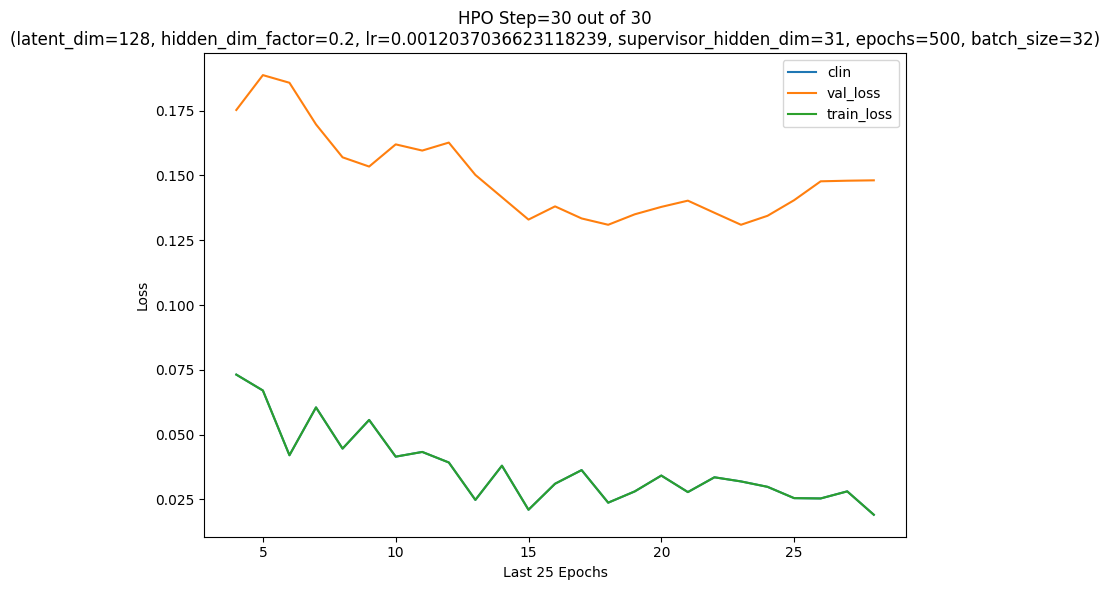

Validation: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│           clin            │    0.14811399579048157    │
│         val_loss          │    0.14811399579048157    │
└───────────────────────────┴───────────────────────────┘

Tuning Progress: 100%|██████████| 30/30 [21:24<00:00, 42.82s/it, Iteration=30, Best Loss=0.115]

[INFO] current best val loss: 0.11472885310649872; best params: {'latent_dim': 20, 'hidden_dim_factor': 0.39092312337913415, 'lr': 0.0004253162363790871, 'supervisor_hidden_dim': 20, 'epochs': 500, 'batch_size': 32} since 24 hpo iterations


In [100]:
# early stopping -  tune the best parameters
tuner = flexynesis.HyperparameterTuning(
    dataset = train_dataset,                # 训练用的数据集
    model_class = flexynesis.DirectPred,   # 用哪种模型结构，这里是简单的全连接网络
    target_variables = ["clin"],# 你想预测哪个变量
    config_name = "DirectPred",             # 调参用的配置名称（超参数空间）
    n_iter=30,                              # 只跑1次超参数搜索（调1组参数）
    plot_losses=True,                      # 打开训练过程的loss打印
    early_stop_patience=10                 # 如果10轮没改进，就停训练
)

model, best_params = tuner.perform_tuning()  # 执行超参数调优，返回最佳模型和参数


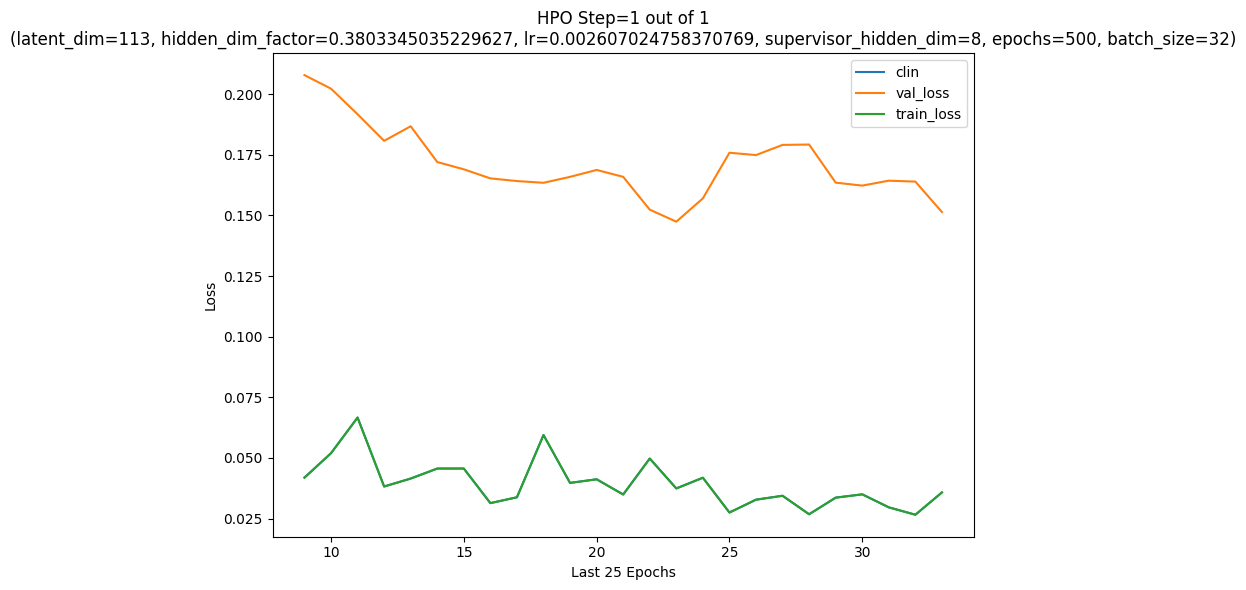

Validation: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│           clin            │    0.1513972282409668     │
│         val_loss          │    0.1513972282409668     │
└───────────────────────────┴───────────────────────────┘

Tuning Progress: 100%|██████████| 1/1 [00:43<00:00, 43.73s/it, Iteration=1, Best Loss=0.151]

[INFO] current best val loss: 0.1513972282409668; best params: {'latent_dim': 113, 'hidden_dim_factor': 0.3803345035229627, 'lr': 0.002607024758370769, 'supervisor_hidden_dim': 8, 'epochs': 500, 'batch_size': 32} since 0 hpo iterations


In [78]:
# full training - not for now
tuner = flexynesis.HyperparameterTuning(dataset = train_dataset, 
                                        model_class = flexynesis.DirectPred, 
                                        target_variables = ["clin"],
                                        config_name = "DirectPred", 
                                        n_iter=HPO_ITER, plot_losses=True,
                                        early_stop_patience=10)
model, best_params = tuner.perform_tuning()

In [102]:
model

DirectPred(
  (log_vars): ParameterDict(  (clin): Parameter containing: [torch.FloatTensor of size 1])
  (encoders): ModuleList(
    (0): MLP(
      (layer_1): Linear(in_features=1149, out_features=449, bias=True)
      (layer_out): Linear(in_features=449, out_features=20, bias=True)
      (relu): ReLU()
      (dropout): Dropout(p=0.1, inplace=False)
      (batchnorm): BatchNorm1d(449, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): MLP(
      (layer_1): Linear(in_features=501, out_features=195, bias=True)
      (layer_out): Linear(in_features=195, out_features=20, bias=True)
      (relu): ReLU()
      (dropout): Dropout(p=0.1, inplace=False)
      (batchnorm): BatchNorm1d(195, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (2): MLP(
      (layer_1): Linear(in_features=904, out_features=353, bias=True)
      (layer_out): Linear(in_features=353, out_features=20, bias=True)
      (relu): ReLU()
      (dropout): Dropout(p=0.1, inpl

In [103]:
best_params

{'latent_dim': 20,
 'hidden_dim_factor': 0.39092312337913415,
 'lr': 0.0004253162363790871,
 'supervisor_hidden_dim': 20,
 'epochs': 73,
 'batch_size': 32}

In [108]:
import os
import json
import torch
import numpy as np

save_dir = r"C:\Users\laura\OneDrive - Imperial College London\project 2\Coding\New models\package\flexynesis\flexynesis\hyper_params"
os.makedirs(save_dir, exist_ok=True)

# 保存模型权重
torch.save(model.state_dict(), os.path.join(save_dir, "best_model_weights.pth"))

# 转换 numpy 类型为 python 原生类型
def convert_np(obj):
    if isinstance(obj, dict):
        return {k: convert_np(v) for k, v in obj.items()}
    elif isinstance(obj, list):
        return [convert_np(i) for i in obj]
    elif isinstance(obj, np.integer):
        return int(obj)
    elif isinstance(obj, np.floating):
        return float(obj)
    elif isinstance(obj, np.ndarray):
        return obj.tolist()
    else:
        return obj

best_params_clean = convert_np(best_params)

# 保存参数json
with open(os.path.join(save_dir, "best_params.json"), "w") as f:
    json.dump(best_params_clean, f, indent=2)

print("模型结构、权重和参数已全部保存！")


✅ 模型结构、权重和参数已全部保存！


# Prediction and model evaluation

In [110]:
y_pred_dict = model.predict(test_dataset)
y_pred_dict

{'clin': array([[ 1.1487296 ],
        [-0.04975617],
        [ 0.60468876],
        [ 0.8093355 ],
        [-0.06277351],
        [-0.04272789],
        [ 0.90086675],
        [ 0.725436  ],
        [ 0.3807935 ],
        [ 0.39339852],
        [ 0.26333386],
        [ 0.08763185],
        [ 0.59488   ],
        [ 0.0116838 ],
        [ 0.00466235],
        [ 0.81343734],
        [-0.23649234],
        [ 1.1507578 ],
        [ 0.5840873 ],
        [ 0.0308216 ],
        [-0.0712848 ],
        [ 0.8367326 ],
        [-0.01015404],
        [ 0.48725548],
        [ 0.52637506],
        [-0.15585186],
        [ 0.5985695 ],
        [ 0.52019215],
        [ 0.03366876],
        [ 0.6665225 ],
        [-0.03208866],
        [ 0.3234151 ],
        [-0.34424868],
        [ 0.5572572 ],
        [ 0.25057298],
        [ 1.02087   ],
        [ 0.4615346 ],
        [ 0.8322239 ],
        [ 0.30092406],
        [ 0.23390181],
        [ 0.32912222],
        [-0.18392873],
        [ 0.7147961 ],
   

In [114]:
print(inspect.getfile(flexynesis.evaluate_wrapper))

C:\Users\laura\OneDrive - Imperial College London\project 2\Coding\New models\package\flexynesis\flexynesis\utils.py


In [112]:
metrics_df = flexynesis.evaluate_wrapper(method = 'DirectPred', y_pred_dict=y_pred_dict, dataset = test_dataset)
metrics_df
# 函数的逻辑是如果是数值型就使用生存分析或者回归分析，但是我们的0和1其实是分类的变量。
# Modify the evaluate_wrapper to get more metrix

,method,var,variable_type,metric,value
0,DirectPred,clin,numerical,mse,0.117026
1,DirectPred,clin,numerical,r2,0.596074
2,DirectPred,clin,numerical,pearson_corr,0.772058
